In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [2]:
df=pd.read_excel("dse13-21.xlsx")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-23,5413.73,5412.19,5451.92,5400.68,-,0.0003
1,2021-03-22,5412.19,5349.77,5418.69,5289.81,-,0.0117
2,2021-03-21,5349.77,5434.69,5434.69,5337.38,-,-0.0156
3,2021-03-18,5434.69,5516.40,5516.40,5414.96,-,-0.0148
4,2021-03-16,5516.40,5532.97,5572.42,5503.38,-,-0.0030


In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
df.index

DatetimeIndex(['2021-03-23', '2021-03-22', '2021-03-21', '2021-03-18',
               '2021-03-16', '2021-03-15', '2021-03-14', '2021-03-11',
               '2021-03-10', '2021-03-09',
               ...
               '2013-02-12', '2013-02-11', '2013-02-10', '2013-02-07',
               '2013-02-06', '2013-02-05', '2013-02-04', '2013-02-03',
               '2013-01-31', '2013-01-30'],
              dtype='datetime64[ns]', name='Date', length=1931, freq=None)

In [4]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

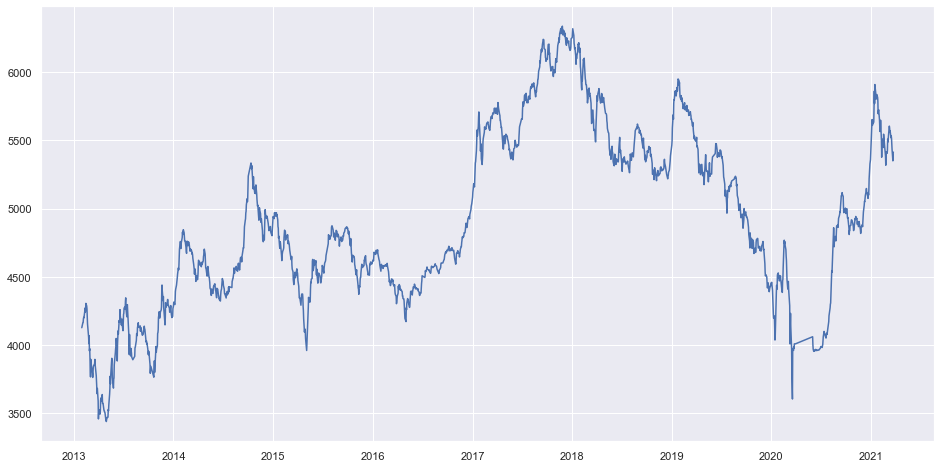

In [5]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Price'], label='Discharge history')

In [6]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Price','Open'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Price"][i]=data['Price'][i]
    new_dataset["Open"][i]=data["Open"][i]

In [7]:
test_data=df.sort_index(ascending=True,axis=0)
test_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Price'])
for i in range(0,len(data)):
    test_dataset["Date"][i]=data['Date'][i]    
    test_dataset["Price"][i]=data["Price"][i]

In [10]:
#test_dataset

In [8]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:1500,:]
valid_data=final_dataset[1500:,:]

In [9]:
test_dataset.index=test_dataset.Date
test_dataset.drop("Date",axis=1,inplace=True)

test_final_dataset=test_dataset.values

test_train_data=test_final_dataset[0:1500,:]
test_valid_data=test_final_dataset[1500:,:]

In [10]:
train_data=new_dataset.iloc[0:1500]

In [11]:
test_train_data=new_dataset.iloc[0:1500]

In [16]:
#train_data

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(test_final_dataset)


In [25]:
x_train_data.shape[0]

1440

In [14]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
# COMPILE THE MODEL

lstm_model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
#  FIT THE MODEL
lstm_model.fit(x_train_data,y_train_data,epochs=25,batch_size=1,verbose=2)

In [21]:
# Take a sample of a dataset to make stock price predictions using the LSTM model

inputs_data=test_dataset[len(test_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
discharge=lstm_model.predict(X_test)
discharge=scaler.inverse_transform(discharge)

In [83]:
#inputs_data

In [22]:
# Save the LSTM model
lstm_model.save("saved_discharge-model.h252")

INFO:tensorflow:Assets written to: saved_discharge-model.h252\assets


INFO:tensorflow:Assets written to: saved_discharge-model.h252\assets


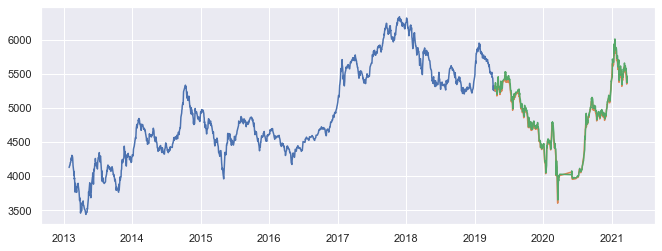

In [23]:
# Visualize the predicted stock costs with actual stock costs
train_data=test_dataset.iloc[0:1500]
valid_data=test_dataset.iloc[1500:]
valid_data['Predictions']=discharge
plt.plot(train_data["Price"])
plt.plot(valid_data[['Price',"Predictions"]])

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(valid_data['Price'], valid_data['Predictions']))
rms

60.238670606483616